In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from distributed_utilities import *
from preprocess_utilities import *

Setting environment for Precision WorkStation


No vtk
No vtk

- After receiving data of a new stack, put images and macros in corresponding folder.
- Add the stack name to proper variables in `metadata.txt`.

In [2]:
stack = 'CHATM3'
# stack = 'ChatCryoJane201710'

In [3]:
# tb_fmt = 'png'
tb_fmt = 'tif'

- Use GUI, quality check and sort images.
- Upload `sorted_filenames.txt` to S3

In [6]:
# transfer_data_synced(os.path.join('CSHL_data', stack), 
#                      from_hostname='s3raw', to_hostname='ec2', is_dir=True, include_only='*.'+tb_fmt)

In [7]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt'), 
#                      from_hostname='s3', to_hostname='ec2', is_dir=False)

# Align

In [4]:
# ! rm /shared/CSHL_data_processed/MD662/MD662_sorted_filenames.txt

In [4]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack, redownload=True) 
# Note that this could be the human-corrected version, in which case the transforms may not exist.
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
print len(valid_filenames), 'valid filenames'

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_sorted_filenames.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_sorted_filenames.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_sorted_filenames.txt"
0
293 valid filenames


In [9]:
version = 'NtbNormalized'

In [10]:
script = os.path.join(REPO_DIR, 'preprocess', 'align_consecutive_v2.py')

# if stack == 'CHATM3':
input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')
# elif stack == 'ChatCryoJane201710':
#     input_dir = os.path.join(THUMBNAIL_DATA_DIR, stack, 'ChatCryoJane201710_thumbnails_%(version)s' % {'version':version})
# else:
#     input_dir = os.path.join(RAW_DATA_DIR, stack)
    
output_dir = create_if_not_exists(os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_elastix_output'))

In [11]:
! rm -r {output_dir}

In [12]:
t = time.time()
print 'Align...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \"%(output_dir)s\" \'%%(kwargs_str)s\' %(fmt)s " % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'fmt': tb_fmt,
                },
                kwargs_list=[{'prev_fn': valid_filenames[i-1] + '_thumbnail_' + version, 
                              'curr_fn': valid_filenames[i] + '_thumbnail_' + version,
                             'prev_sn': valid_filenames[i-1] ,
                             'curr_sn': valid_filenames[i] } 
                             for i in range(1, len(valid_filenames))],
                argument_type='list',
                jobs_per_node=8,
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 252 seconds

Align...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 1851.03668308 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [13]:
upload_to_s3(output_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_elastix_output" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_elastix_output"
0


# Check final metrics

In [14]:
import re

final_metric = {}
for i in range(1, len(valid_filenames)):
#     if stack == 'ChatCryoJane201710':
#         prev_fn = valid_filenames[i-1] + '-Ntb'
#         curr_fn = valid_filenames[i] + '-Ntb'
#     else:
    prev_fn = valid_filenames[i-1]
    curr_fn = valid_filenames[i]

    with open(os.path.join(output_dir, curr_fn + '_to_' + prev_fn, 'elastix.log'), 'r') as f:
        t = f.read()
        g = re.search("Final metric value  = (.*?)\n", t)
#         final_metric[(curr_fn, prev_fn)] = -float(g.groups()[0])
        if g is None:
            print i
        final_metric[i] = float(g.groups()[0])

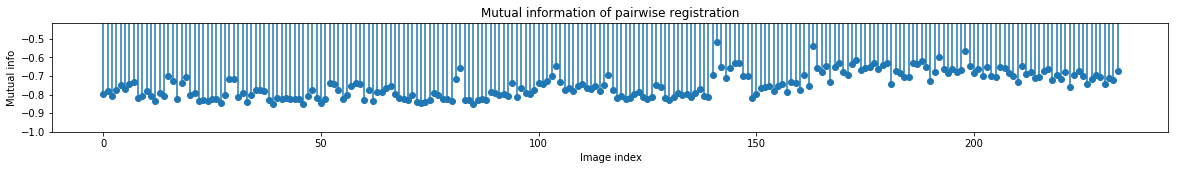

In [15]:
%matplotlib inline
metric_arr = np.array(final_metric.values())
plt.figure(figsize=(20,2));
plt.ylim([-1, metric_arr.max()+.1]);
plt.stem(metric_arr);
plt.title('Mutual information of pairwise registration');
plt.yticks(np.arange(-1, metric_arr.max()+.1, 0.1));
plt.xlabel('Image index');
plt.ylabel('Mutual info');

In [16]:
problematic_moving_indices = np.where(abs(metric_arr) < .6)[0] + 1

print 'Pairs to check (moving, fixed):'
[(valid_filenames[moving_ind], valid_filenames[moving_ind-1]) for moving_ind in problematic_moving_indices]

Pairs to check (moving, fixed):


[('CHATM2_slide52_2018_01_22-S1', 'CHATM2_slide51_2018_01_22-S1'),
 ('CHATM2_slide62_2018_02_14-S1', 'CHATM2_slide57_2018_01_22-S3'),
 ('CHATM2_slide82_2018_02_14-S1', 'CHATM2_slide80_2018_02_14-S3'),
 ('CHATM2_slide86_2018_02_13-S1', 'CHATM2_slide84_2018_02_14-S3')]

In [17]:
q = np.argmin(np.abs(final_metric.values()))
print 'worst pair (moving, fixed):', valid_filenames[q], valid_filenames[q-1]

worst pair (moving, fixed): CHATM2_slide51_2018_01_22-S1 CHATM2_slide50_2018_01_22-S3


- download `elastix_output/` to local machine, edit consecutive transforms in local GUI, generate `custom_transforms/` to S3, upload to S3.
- determine anchor image, upload `anchor.txt` to S3.

# Compose consecutive transforms

In [173]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_elastix_output'), 
                     from_hostname='s3', to_hostname='ec2', is_dir=True)

rm -rf "/shared/CSHL_data_processed/MD661/MD661_elastix_output" && mkdir -p "/shared/CSHL_data_processed/MD661"
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_elastix_output" "/shared/CSHL_data_processed/MD661/MD661_elastix_output"


In [56]:
download_from_s3(os.path.join('CSHL_data_processed', stack, stack + '_custom_transforms'), 
                 is_dir=True, local_root=DATA_ROOTDIR)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_custom_transforms" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_custom_transforms" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_custom_transforms"
0


In [57]:
download_from_s3(os.path.join('CSHL_data_processed', stack, stack + '_anchor.txt'), 
                     is_dir=False,
                    local_root=DATA_ROOTDIR)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_anchor.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM3/CHATM3_anchor.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM3/CHATM3_anchor.txt"
0


In [11]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)
# if stack == 'ChatCryoJane201710':
#     anchor_idx = valid_filenames.index(anchor_fn + '-Chat')
# else:
anchor_idx = valid_filenames.index(anchor_fn)
print 'anchor_idx =', anchor_idx

anchor_idx = 163


In [19]:
script = os.path.join(REPO_DIR, 'preprocess', 'compose_transform_thumbnail_v2.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_elastix_output')
output_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                         dict(stack=stack, anchor_fn=anchor_fn))

In [20]:
! rm -f "{output_fp}"

In [21]:
t = time.time()
print 'Composing transform...'

run_distributed("%(script)s %(stack)s \"%(input_dir)s\" \'%%(kwargs_str)s\' %(anchor_idx)d \"%(output_fp)s\"" % \
            {'stack': stack,
            'script': script,
            'input_dir': input_dir,
            'anchor_idx': anchor_idx,
            'output_fp': output_fp},
            kwargs_list=[{'filenames': valid_filenames}],
            argument_type='list',
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds

Composing transform...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 14.4790461063 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [22]:
upload_to_s3(output_fp)

aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide57_2018_01_22-S3.pkl" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide57_2018_01_22-S3.pkl"
0


# Warp

In [12]:
transforms_fp = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_%(anchor_fn)s.pkl' % \
                                                dict(stack=stack, anchor_fn=anchor_fn))
download_from_s3(transforms_fp, redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide57_2018_01_22-S3.pkl" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide57_2018_01_22-S3.pkl" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_transformsTo_CHATM2_slide57_2018_01_22-S3.pkl"
0


In [13]:
# if stack in all_nissl_stacks:
#     pad_bg_color = 'white'
# elif stack == 'ChatCryoJane201710':
#     pad_bg_color = 'black'
# else:
pad_bg_color = 'black'

In [14]:
prep_id = 1

In [15]:
version = 'NtbNormalized'

In [16]:
if stack in ['CHATM3', 'CHATM2']:
    input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol='thumbnail')
else:
    input_dir = os.path.join(RAW_DATA_DIR, stack)

out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=prep_id, resol='thumbnail', version=version)
print 'out_dir:', out_dir
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

out_dir: /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized


In [17]:
! rm -rf {out_dir}

In [31]:
t = time.time()
print 'Warping...'

transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, anchor_fn=anchor_fn)

if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %%(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    },
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': os.path.join(input_dir, \
                                                        fn + '_thumbnail_' + version + '.' + tb_fmt \
                                              if version is not None \
                                              else fn + '.' + tb_fmt),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol='thumbnail'),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)
else:
    run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s thumbnail 0 0 2000 1500 %(pad_bg_color)s' % \
                    {'script': script,
                    'stack': stack,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                                'input_fp': os.path.join(input_dir, \
                                                        fn + '_thumbnail_' + version + '.' + tb_fmt \
                                              if version is not None \
                                              else fn + '.' + tb_fmt),
                                  'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, prep_id=prep_id, version=version, resol='thumbnail'),
                                 }
                                for fn in valid_filenames],
                    argument_type='single',
                   jobs_per_node=8,
                   local_only=True)

# wait_qsub_complete()
    
print 'done in', time.time() - t, 'seconds' # 300 seconds.

Warping...
rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


done in 48.9562909603 seconds


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [32]:
upload_to_s3(out_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized"
0


- Download aligned images to local. In GUI, check alignment correctness.
- Place cropbox. Upload `cropbox.txt` to S3.
- If section order is altered, redo the process starting from "Align".

- (Recommended) Run `reconstruct/construct_thumbnail_volume_v3.ipynb` notebook. Check the smoothness of virtual re-sectioning in brain labeling gui.

# Crop

In [33]:
stack = 'CHATM2'
download_from_s3(DataManager.get_cropbox_filename(stack), redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_alignedTo_CHATM2_slide57_2018_01_22-S3_cropbox.txt" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_alignedTo_CHATM2_slide57_2018_01_22-S3_cropbox.txt" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_alignedTo_CHATM2_slide57_2018_01_22-S3_cropbox.txt"
0


In [34]:
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin

print x,y,w,h

524 97 788 570


In [207]:
# first_fn = sections_to_filenames[first_sec]
# last_fn = sections_to_filenames[last_sec]

In [208]:
# first_idx_among_valid = valid_filenames.index(first_fn)
# last_idx_among_valid = valid_filenames.index(last_fn)

# Crop Thumbnail

In [36]:
# input_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s" % \
#                            {'stack': stack, 'anchor_fn': anchor_fn})

# output_dir = os.path.join(DATA_DIR, stack, "%(stack)s_thumbnail_alignedTo_%(anchor_fn)s_cropped" % \
#                            {'stack': stack, 'anchor_fn': anchor_fn})

input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=1, resol='thumbnail', version='NtbNormalized')
download_from_s3(input_dir, is_dir=True, local_root=DATA_ROOTDIR)

output_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=2, resol='thumbnail', version='NtbNormalized')
execute_command('rm -r ' + output_dir);
execute_command('mkdir -p ' + output_dir);

rm -r /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized
1
mkdir -p /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized
0


In [37]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [41]:
for img_name in valid_filenames:
# for img_name in ['CHATM3_slide69_2018_02_19-S3']:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=1, fn=img_name, resol='thumbnail', version='NtbNormalized')
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=img_name, resol='thumbnail', version='NtbNormalized')
    create_parent_dir_if_not_exists(out_fp)
    
    cmd = 'convert \"%(in_fp)s\" -crop %(w)dx%(h)d+%(x)d+%(y)d  \"%(out_fp)s\"' % \
    {'in_fp': in_fp, 'out_fp': out_fp, 'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin}
    execute_command(cmd)
        
    sys.stderr.write("Crop: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide01_2

Crop: 0.07 seconds.
Crop: 0.08 seconds.
Crop: 0.07 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide01_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide02_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide02

Crop: 0.07 seconds.
Crop: 0.07 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide03

Crop: 0.07 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide03_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide04_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide04

Crop: 0.08 seconds.
Crop: 0.07 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide05

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.07 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide05_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide06_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide06

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.07 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide07

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide07_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide08_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide08

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide09

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide09_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide10_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide10

Crop: 0.07 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide11

Crop: 0.08 seconds.
Crop: 0.07 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide11_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide12_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide12

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide13

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide13_2018_01_19-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide14_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide14

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide15

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.07 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide15_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide16_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide16

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide17

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide17_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide18_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide18

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.07 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide19

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide19_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide20_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide20

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide21

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide21_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide22_2018_01_19-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide22

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide23

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide23_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide24_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide24

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide25

Crop: 0.08 seconds.
Crop: 0.10 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide25_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide26_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide26

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide27

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide27_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide28_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide28

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide29

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide29_2018_01_18-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide30_2018_01_18-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide30

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide32

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide31_2018_01_19-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide32_2018_01_20-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide33

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide34

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide33_2018_01_20-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide34_2018_01_20-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide35

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide35_2018_01_20-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide36

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide36_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide38

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide37_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide37

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide39

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide39_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide42

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide41_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide41

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide42_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide44

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide43_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide43

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide44_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide46

Crop: 0.10 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide45_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide45

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide46_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide48

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide48_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide50

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide49_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide50_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide50

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide51

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide52_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide52

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide53

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide54_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide54

Crop: 0.09 seconds.
Crop: 0.10 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide55

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide56_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide56

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide57

Crop: 0.10 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide62

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide64

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide66

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide68

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.10 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide68_2018_02_14-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide70

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide70_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide72

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide72_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide74

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide74_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide76

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide76_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide78

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide78_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide80

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide80_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide82

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide82_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide84

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide84_2018_02_14-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide86

Crop: 0.09 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide86_2018_02_13-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide88

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide88_2018_02_13-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide90

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide90_2018_02_13-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide92

Crop: 0.09 seconds.
Crop: 0.08 seconds.
Crop: 0.09 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide92_2018_02_13-S3_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide94_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide94

Crop: 0.21 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide96_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide96

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide98_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide98

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide100_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_sl

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide102_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_sl

Crop: 0.08 seconds.
Crop: 0.09 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide104_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_sl

Crop: 0.07 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide106_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_sl

Crop: 0.08 seconds.
Crop: 0.08 seconds.
Crop: 0.08 seconds.


0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S1_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S1_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S2_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S2_prep2_thumbnail_NtbNormalized.tif"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_NtbNormalized/CHATM2_slide108_2018_02_13-S3_prep1_thumbnail_NtbNormalized.tif" -crop 788x570+524+97  "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_sl

Crop: 0.07 seconds.
Crop: 0.08 seconds.
Crop: 0.07 seconds.


0


Crop: 0.08 seconds.


In [35]:
# t = time.time()
# sys.stderr.write('cropping thumbnail...')

# for fn in valid_filenames:

#     execute_command('convert \"%(input_fp)s\" -crop %(w)dx%(h)d+%(x)d+%(y)d  \"%(output_fp)s\"' % \
#         {'stack': stack,
#         'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=1, fn=fn, resol='thumbnail', version='NtbNormalized'),
#         'output_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='thumbnail', version='NtbNormalized'),
#         'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin})

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 70s (aws)

In [154]:
# t = time.time()
# sys.stderr.write('cropping thumbnail...')

# execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write "%(output_dir)s/%%[filename:name]_cropped.tif" %(input_dir)s/*.tif' % \
#     {'input_dir': input_dir,
#      'output_dir': output_dir,
#     'w':w, 'h':h, 'x':x, 'y':y})

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 100 seconds

In [42]:
upload_to_s3(output_dir, is_dir=True, local_root=DATA_ROOTDIR)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized"
0


In [78]:
# transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_thumbnail_alignedTo_' + anchor_fn + '_cropped'),
#                     from_hostname='ec2',
#                     to_hostname='s3',
#                     is_dir=True)

# Expand lossless JP2 (use /shared)

In [7]:
stack = 'MD662'

In [ ]:
transfer_data_synced(os.path.join('CSHL_data', stack),
                    from_hostname='s3raw',
                    to_hostname='ec2',
                    is_dir=True,
                    include_only='*_lossless.jp2')

aws s3 cp --recursive "s3://mousebrainatlas-rawdata/CSHL_data/MD661" "/shared/CSHL_data/MD661" --exclude "*" --include "*_lossless.jp2"


In [88]:
output_dir = create_if_not_exists(DataManager.get_image_dir_v2(stack=stack, prep_id=1, resol='lossless'))

In [ ]:
t = time.time()
sys.stderr.write('expanding...')

in_fps = [fn + '_lossless.jp2' for fn in metadata_cache['valid_filenames'][stack]]
out_fps = [DataManager.get_image_filepath_v2(stack=stack, prep_id=1, resol='lossless', fn=fn) 
           for fn in metadata_cache['valid_filenames'][stack]]

run_distributed('export LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH; %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(out_fp)s\"' % \
                {'kdu_bin': KDU_EXPAND_BIN},
                kwargs_list={'in_fp': in_fps, 'out_fp': out_fps},
                argument_type='single',
               cluster_size=16)

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

In [ ]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True) # 6000s

# Transform and crop lossless (use /shared)

In [24]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_tif'),
                    from_hostname='s3',
                    to_hostname='ec2',
                    is_dir=True)
# 3000 seconds

rm -rf /shared/CSHL_data_processed/MD585/MD585_lossless_tif && mkdir -p /shared/CSHL_data_processed/MD585
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_lossless_tif /shared/CSHL_data_processed/MD585/MD585_lossless_tif


Child returned 0


3079.07781506


Child returned 0
3079.08 seconds.


In [37]:
# tf_filepath = os.path.join(DATA_DIR, stack, '%(stack)s_transformsTo_anchor.pkl' % {'stack':stack})
# tfs = pickle.load(open(tf_filepath, 'r'))
# Note that the index from trasform pickle file starts at 0, BUT the .._renamed folder index starts at 1.#

tfs = DataManager.load_transforms(stack=stack)

lossless_tif_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_tif')
lossless_aligned_cropped_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped')

script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v2.py')

In [45]:
! rm -r {lossless_aligned_cropped_dir}

In [43]:
if stack in all_nissl_stacks:
    pad_bg_color = 'white'
else:
    pad_bg_color = 'auto'

In [ ]:
t = time.time()
sys.stderr.write('warping and cropping lossless...')

# wait_num_nodes(16)
                   
if pad_bg_color == 'auto':
    # If alternating, then black padding for F sections, white padding for N sections.
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif',
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
#                                  for fn in valid_filenames[first_idx_among_valid:first_idx_among_valid+16]],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=4)
else:
    run_distributed(command='%(script_path)s %(stack)s %(lossless_tif_dir)s %(lossless_aligned_cropped_dir)s %%(transform)s %%(filename)s %%(output_fn)s lossless %(x)d %(y)d %(w)d %(h)d %(pad_bg_color)s'%\
                    {'script_path': script_fp,
                    'stack': stack,
                    'lossless_tif_dir': lossless_tif_dir,
                    'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                    'x': x,
                    'y': y,
                    'w': w,
                    'h': h,
                    'pad_bg_color': pad_bg_color},
                    kwargs_list=[{'transform': ','.join(map(str, tfs[fn].flatten())),
                                'filename': fn + '_lossless.tif',
                                'output_fn': fn + '_lossless_alignedTo_' + anchor_fn + '_cropped.tif'}
                                for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]],
#                                  for fn in valid_filenames[first_idx_among_valid:first_idx_among_valid+16]],
                    argument_type='single',
                   cluster_size=16,
                   jobs_per_node=4)

wait_qsub_complete()
    
sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 4140 seconds (AWS)

In [24]:
transfer_data_synced(os.path.join('CSHL_data_processed', stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped'),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True) 
# 512 seconds

aws s3 cp --recursive /shared/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped s3://mousebrainatlas-data/CSHL_data_processed/MD658/MD658_lossless_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_cropped


Child returned 0
1064.17 seconds.


# Transform and crop raw (For UCSD Data)

In [33]:
prep_id = 2

In [34]:
_, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [35]:
xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
w = xmax + 1 - xmin
h = ymax + 1 - ymin
x = xmin
y = ymin

print x,y,w,h

524 97 788 570


In [36]:
anchor_fn = DataManager.load_anchor_filename(stack=stack)
transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False, anchor_fn=anchor_fn)

In [37]:
if stack == 'CHATM2':
    image_filename_to_orientation_mapping = \
    {img_name: 'top_posterior_left_ventral' for img_name in valid_filenames
    }

In [38]:
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

In [39]:
pad_bg_color = 'black'

In [40]:
# fns_not_yet_converted = sorted(list(set(valid_filenames) - \
# set([fp[:-24] for fp in os.listdir('/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_lossless_CHAT/')])))
# print len(fns_not_yet_converted)

In [41]:
def section_orientation_to_argparse_str(orientation):
    """
    These cannot contain - or space.
    """

    if orientation == 'top_anterior_left_dorsal':
        init_rotate = 'transpose'
    elif orientation == 'top_anterior_left_ventral':
        init_rotate = 'rotate90'
    elif orientation == 'top_posterior_left_ventral':
        init_rotate = 'transverse'
    else:
        init_rotate = ''
    
    return init_rotate

In [42]:
# orientation_argparse_str_to_imagemagick_str = \
# {'transpose': '-transpose',
#  'transverse': '-transverse',
#  'rotate90': '-rotate 90'
# }

In [43]:
# def section_orientation_to_imagemagick_str(orientation):

#     if orientation == 'top_anterior_left_dorsal':
#         init_rotate = '-transpose'
#     elif orientation == 'top_anterior_left_ventral':
#         init_rotate = '-rotate 90'
#     elif orientation == 'top_posterior_left_ventral':
#         init_rotate = '-transverse'
#     else:
#         init_rotate = ''
    
#     return init_rotate

This takes 10 hours for one version, 235 sections.

In [ ]:
for version in ['CHAT']:

    t = time.time()

    if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
        run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s raw %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s -r \"%%(init_rotate)s\"' % \
                        {'script': script,
                        'stack': stack,
                         'x': x,
                        'y': y,
                        'w': w,
                        'h': h,
                        },
                        kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                    'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version=version, fn=img_name),
                                      'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=prep_id, version=version, resol='raw'),
                                    'pad_bg_color': 'black' if img_name.split('-')[1][0] == 'F' else 'white',
                                     'init_rotate': section_orientation_to_argparse_str(image_filename_to_orientation_mapping[img_name])
                                     }
                                    for img_name in valid_filenames
                                    ],
                        argument_type='single',
                       jobs_per_node=1,
                       local_only=True)
    else:
        run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s raw %(x)d %(y)d %(w)d %(h)d %(pad_bg_color)s -r \"%%(init_rotate)s\"' % \
                        {'script': script,
                        'stack': stack,
                         'x': x,
                        'y': y,
                        'w': w,
                        'h': h,
                        'pad_bg_color': pad_bg_color
                        },
                        kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                    'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version=version, fn=img_name),
                                      'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=prep_id, version=version, resol='raw'),
                                      'init_rotate': section_orientation_to_argparse_str(image_filename_to_orientation_mapping[img_name])
                                     }
                                    for img_name in valid_filenames
                                    ],
                        argument_type='single',
                       jobs_per_node=1,
                       local_only=True)

    # wait_qsub_complete()

    print 'done in', time.time() - t, 'seconds' # 300 seconds.

rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


# Expand, transform and crop together (use /scratch)

In [7]:
stack = 'MD662'

In [8]:
tfs = DataManager.load_transforms(stack=stack, downsample_factor=32, use_inverse=False)

# Option 1: Crop brainstem

In [ ]:
# xmin, xmax, ymin, ymax = metadata_cache['cropbox'][stack]
xmin, xmax, ymin, ymax = DataManager.load_cropbox(stack)[:4]
print xmin, xmax, ymin, ymax

In [12]:
raw_jp2_dir = DataManager.get_image_dir(stack=stack, resol='lossless', version='original_jp2', raw_data_dir='/scratch/CSHL_data')
lossless_tif_dir = DataManager.get_image_dir_v2(stack=stack, resol='lossless', prep_id=0, data_dir='/scratch/CSHL_data_processed')
lossless_aligned_cropped_dir = DataManager.get_image_dir_v2(stack=stack, resol='lossless', prep_id=2, data_dir='/scratch/CSHL_data_processed')

In [ ]:
run_distributed('rm -rf /scratch/*', argument_type='single')

In [ ]:
t = time.time()
sys.stderr.write('expanding...')

warp_crop_script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

run_distributed('aws s3 cp \"s3://mousebrainatlas-rawdata/CSHL_data/%(stack)s/%%(fn)s_lossless.jp2\" \"%(raw_jp2_dir)s\"/ && \
mkdir -p \"%(lossless_tif_dir)s\" && \
LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(lossless_tif_fp)s\" && \
mkdir -p \"%(lossless_aligned_cropped_dir)s\" && \
%(script_path)s %(stack)s \"%%(lossless_tif_fp)s\" \"%%(lossless_aligned_cropped_fp)s\" %%(transform)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s && \
aws s3 cp \"%%(lossless_aligned_cropped_fp)s\" \"s3://mousebrainatlas-data/%(s3_dest_dir)s/\"' % \
                {'stack': stack,
                'kdu_bin': KDU_EXPAND_BIN,
                'raw_jp2_dir': raw_jp2_dir,
                'script_path': warp_crop_script_fp,
                'lossless_tif_dir': lossless_tif_dir,
                'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                 's3_dest_dir': relative_to_local(lossless_aligned_cropped_dir, local_root='/scratch'),
                'x': xmin,
                'y': ymin,
                'w': xmax + 1 - xmin,
                'h': ymax + 1 - ymin},
                kwargs_list=[{'fn': fn, 
                              'in_fp': os.path.join(raw_jp2_dir, fn + '_lossless.jp2'),
                              'transform': ','.join(map(str, tfs[fn].flatten())),
                                'lossless_tif_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, resol='lossless', prep_id=0, data_dir='/scratch/CSHL_data_processed'),
                                'lossless_aligned_cropped_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, resol='lossless', prep_id=2, data_dir='/scratch/CSHL_data_processed'),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                             for fn in metadata_cache['valid_filenames'][stack]],
                argument_type='single')

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 
# 16 4.2xlarge, whole stack,4222 seconds.
# 4 4.xlarge nodes, whole stack, 10280 seconds.

# Option 2: Crop entire-brain

In [9]:
# for sec in metadata_cache['valid_sections'][stack]:
bboxes_all_secs = {}
for sec in metadata_cache['valid_sections_all'][stack]:
    mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, prep_id=1)
    bboxes_all_secs[sec] = bbox_2d(mask)

In [10]:
q = np.array(bboxes_all_secs.values())
xmin, ymin = np.min(q[:, [0,2]], axis=0)
xmax, ymax = np.max(q[:, [1,3]], axis=0)
margin = 50
xmin, xmax, ymin, ymax = (xmin - margin, xmax + margin, ymin - margin, ymax + margin)
print xmin, xmax, ymin, ymax

118 1374 130 777


In [11]:
raw_jp2_dir = DataManager.get_image_dir(stack=stack, resol='lossless', version='original_jp2', raw_data_dir='/scratch/CSHL_data')
lossless_tif_dir = DataManager.get_image_dir_v2(stack=stack, resol='lossless', prep_id=0, data_dir='/scratch/CSHL_data_processed')
lossless_aligned_cropped_dir = DataManager.get_image_dir_v2(stack=stack, resol='lossless', prep_id=5, data_dir='/scratch/CSHL_data_processed')

In [19]:
run_distributed('rm -rf /scratch/*', argument_type='single')

rm -f ~/stderr_*; rm -f ~/stdout_*


9 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [21]:
t = time.time()
sys.stderr.write('expanding...')

warp_crop_script_fp = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

run_distributed('aws s3 cp \"s3://mousebrainatlas-rawdata/CSHL_data/%(stack)s/%%(fn)s_lossless.jp2\" \"%(raw_jp2_dir)s\"/ && \
mkdir -p \"%(lossless_tif_dir)s\" && \
LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(lossless_tif_fp)s\" && \
mkdir -p \"%(lossless_aligned_cropped_dir)s\" && \
%(script_path)s %(stack)s \"%%(lossless_tif_fp)s\" \"%%(lossless_aligned_cropped_fp)s\" %%(transform)s lossless %(x)d %(y)d %(w)d %(h)d %%(pad_bg_color)s && \
aws s3 cp \"%%(lossless_aligned_cropped_fp)s\" \"s3://mousebrainatlas-data/%(s3_dest_dir)s/\"' % \
                {'stack': stack,
                'kdu_bin': KDU_EXPAND_BIN,
                'raw_jp2_dir': raw_jp2_dir,
                'script_path': warp_crop_script_fp,
                'lossless_tif_dir': lossless_tif_dir,
                'lossless_aligned_cropped_dir': lossless_aligned_cropped_dir,
                 's3_dest_dir': relative_to_local(lossless_aligned_cropped_dir, local_root='/scratch'),
                'x': xmin,
                'y': ymin,
                'w': xmax + 1 - xmin,
                'h': ymax + 1 - ymin},
                kwargs_list=[{'fn': fn, 
                              'in_fp': os.path.join(raw_jp2_dir, fn + '_lossless.jp2'),
                              'transform': ','.join(map(str, tfs[fn].flatten())),
                                'lossless_tif_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, resol='lossless', prep_id=0, data_dir='/scratch/CSHL_data_processed'),
                                'lossless_aligned_cropped_fp': DataManager.get_image_filepath_v2(stack=stack, fn=fn, resol='lossless', prep_id=5, data_dir='/scratch/CSHL_data_processed'),
                                'pad_bg_color': 'black' if fn.split('-')[1][0] == 'F' else 'white'}
                             for fn in metadata_cache['valid_filenames_all'][stack]],
                argument_type='single')

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 
# 16 4.2xlarge, whole stack,4222 seconds.
# 4 4.xlarge nodes, whole stack, 10280 seconds.

expanding...15 nodes available.


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 11369.358836 seconds


# Convert images to nissl-like grayscale - for full nissl stacks

In [ ]:
# for stack in all_nissl_stacks:
for stack in ['MD595']:
    
    download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
    _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
    
    valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
    download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))

    _, _, _, _, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
    first_fn = sections_to_filenames[first_sec]
    last_fn = sections_to_filenames[last_sec]
    first_idx_among_valid = valid_filenames.index(first_fn)
    last_idx_among_valid = valid_filenames.index(last_fn)

    # Convert Nissl images to grayscale
    
    t = time.time()
    sys.stderr.write('Convert nissl images to gray...')

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

    run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                        {'script_path': script_fp, 'stack': stack},
                        kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                    },
                        argument_type='list2')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

# Convert images to nissl-like grayscale - for alternating nissl/neurotrace stacks

In [269]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD653', 'MD657']:
    
    download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
    _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
    
    valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
    download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))

    _, _, _, _, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
    first_fn = sections_to_filenames[first_sec]
    last_fn = sections_to_filenames[last_sec]
    first_idx_among_valid = valid_filenames.index(first_fn)
    last_idx_among_valid = valid_filenames.index(last_fn)

    # Convert Nissl images to grayscale
    
    t = time.time()
    sys.stderr.write('Convert nissl images to gray...')

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

    run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                        {'script_path': script_fp, 'stack': stack},
                        kwargs_list={'filenames': 
                                     [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                      if fn.split('-')[1][0] == 'N']
                                    },
                        argument_type='list2',
                       cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.
    
    # Match intensity profile between Neurotrace Blue to Nissl

    t = time.time()
    sys.stderr.write('Match intensity profile between Neurotrace and Nissl...')

    filename_pairs = []
    l = valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
    for i, fn in enumerate(l):
        if l[i].split('-')[1][0] == 'F':
            for d in range(1, 99):
                if i+d < len(l) and l[i+d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i+d], l[i]))
                    break
                if i-d >= 0 and l[i-d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i-d], l[i]))
                    break
            
    script_fp = os.path.join(REPO_DIR, 'preprocess', 'match_intensity_profile.py')
    
    run_distributed(command='%(script_path)s %(stack)s \'%%(filename_pairs)s\' ' % \
                    {'script_path': script_fp,
                    'stack': stack,
                    'filename_pairs': filename_pairs},
                    kwargs_list=dict(filename_pairs=filename_pairs),
                    argument_type='list2',
                   cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds. 
    # TODO: One node is especially slow, investigate.
    
    # Convert Neurotrace images to grayscale
    
    t = time.time()
    sys.stderr.write('Convert neurotrace images to gray...')
    
    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')
    
    run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                        {'script_path': script_fp, 
                        'stack': stack},
                        kwargs_list={'filenames': [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                      if fn.split('-')[1][0] == 'F']
                                    },
                        argument_type='list2',
                       cluster_size=16)

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 1200 seconds.    

Convert nissl images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1098.395771 seconds
16 nodes requested, 16 nodes available...Continuing


Match intensity profile between Neurotrace and Nissl...

Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing


 done in 2371.7916441 seconds


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1008.132029 seconds
Convert nissl images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1053.684169 seconds
16 nodes requested, 16 nodes available...Continuing


Match intensity profile between Neurotrace and Nissl...

Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing


 done in 3785.25425816 seconds


Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 1298.919096 seconds


# Convert images to nissl-like grayscale - for full neurotrace stacks

In [41]:
run_distributed('rm -rf /scratch/*', argument_type='single')

rm -f ~/stderr_*; rm -f ~/stdout_*


16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [42]:
# Convert Neurotrace images to grayscale using a priori intensity mapping.

for stack in ['MD662']:    
    prep_id = 5
    
    t = time.time()
    sys.stderr.write('Convert neurotrace images to gray...')
    
    script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')
    
    run_distributed(command='ROOT_DIR=/scratch/ DATA_ROOTDIR=/scratch/ %(script_path)s %(stack)s \'%%(filenames)s\' -p %(prep_id)d'%\
                        {'script_path': script_fp, 
                        'stack': stack,
                        'prep_id': prep_id},
                        kwargs_list={'filenames': metadata_cache['valid_filenames_all'][stack]},
                        argument_type='list2')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2000 seconds.    

Convert neurotrace images to gray...16 nodes available.


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 2428.562770 seconds


# ONE STACK

# Step 1: Convert Nissl images to grayscale

In [ ]:
t = time.time()
sys.stderr.write('Convert nissl images to gray...')
               
script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\''%\
                    {'script_path': script_fp, 'stack': stack},
#                     kwargs_list={'filenames': valid_filenames[first_idx_among_valid:last_idx_among_valid+1]},
                    kwargs_list={'filenames':
                                 [fn for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
                                  if fn.split('-')[1][0] == 'N']},
                    argument_type='list2',
                   cluster_size=16)

wait_qsub_complete()

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 1200 seconds.

In [44]:
# Convert contrast-stretched Neurotrace images to grayscale

# script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace.py')
# in_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched')
# out_dir = os.path.join(DATA_DIR, stack, stack + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched_blueasgray')
# ! mkdir -p {out_dir}

In [57]:
# t = time.time()
# sys.stderr.write('Convert neurotrace images to gray...')
               
# run_distributed(command='%(script_path)s %%(in_fn)s %%(out_fn)s'%\
#                     {'script_path': script_fp},
#                     kwargs_list=[{'in_fn': os.path.join(in_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched.tif'),
#                                 'out_fn': os.path.join(out_dir, fn + '_lossless_alignedTo_' + anchor_fn + '_cropped_contrast_stretched_blueasgray.tif')}
# #                                 for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]
#                                  for fn in valid_filenames[150:151]
#                                 if fn.split('-')[1][0] == 'F'],
#                     argument_type='single',
#                    cluster_size=16)

# wait_qsub_complete()

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 2500 seconds

Convert neurotrace images to gray...16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.
qsub returned.
done in 75.575123 seconds


# Step 2: Match intensity profile between Neurotrace Blue to Nissl

In [122]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD653', 'MD652', 'MD642', 'MD658']:

#     download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
#     _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
#     valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
#     download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))
#     anchor_fn = DataManager.load_anchor_filename(stack=stack)
#     download_from_s3(DataManager.get_cropbox_filename(stack=stack))
#     xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
#     w = xmax + 1 - xmin
#     h = ymax + 1 - ymin
#     x = xmin
#     y = ymin
#     first_fn = sections_to_filenames[first_sec]
#     last_fn = sections_to_filenames[last_sec]
#     first_idx_among_valid = valid_filenames.index(first_fn)
#     last_idx_among_valid = valid_filenames.index(last_fn)
    
    #########################################################
    
    t = time.time()
    print 'Match intensity profile between Neurotrace and Nissl...',
    
    filename_pairs = []
    l = metadata_cache['valid_filenames'][stack]
    for i, fn in enumerate(l):
        if l[i].split('-')[1][0] == 'F':
            for d in range(1, 99):
                if i+d < len(l) and l[i+d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i+d], l[i]))
                    break
                if i-d >= 0 and l[i-d].split('-')[1][0] == 'N':
                    filename_pairs.append((l[i-d], l[i]))
                    break
    
    script = os.path.join(REPO_DIR, 'preprocess', 'match_intensity_profile_v2.py')
    
    run_distributed(command='%(script_path)s %(stack)s \'%%(filename_pairs)s\' 100' % \
                    {'script_path': script,
                    'stack': stack},
#                     kwargs_list=dict(filename_pairs=filename_pairs[37:38]),
                    kwargs_list=dict(filename_pairs=filename_pairs),
                    argument_type='list2'
                   )

    wait_qsub_complete()

    print 'done in', time.time() - t, 'seconds'

Match intensity profile between Neurotrace and Nissl... rm -f ~/stderr_*; rm -f ~/stdout_*


Child returned 0
16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
Child returned 0
16 nodes available.


done in 2790.67252398 seconds
Match intensity profile between Neurotrace and Nissl... rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
Child returned 0
16 nodes available.


done in 2554.21281099 seconds
Match intensity profile between Neurotrace and Nissl... rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
Child returned 0
16 nodes available.


done in 2655.20303488 seconds
Match intensity profile between Neurotrace and Nissl... rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 2363.96758008 seconds


qsub returned.


# Step 3: Convert Neurotrace images to grayscale (New, use nonlinear intensity mapping)

In [6]:
request_compute_nodes(16, 'yuncong')

Setting autoscaling group cfncluster-yuncongcluster-ComputeFleet-1LEH9CIEITL1A capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


In [7]:
run_distributed('rm -rf /scratch/*', argument_type='single')

rm -f ~/stderr_*; rm -f ~/stdout_*


0 nodes available.


In [8]:
# for fn in valid_filenames[first_idx_among_valid:last_idx_among_valid+1]:
#     download_from_s3(DataManager.get_image_filepath(stack=stack, version='cropped', resol='lossless', fn=fn))

This requires at least 4.2xlarge instances. 4.xlarge causes memory error.

In [101]:
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [8]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

In [9]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD652', 'MD653']:
    
#     output_dir = create_if_not_exists(DataManager.get_image_dir_v2(stack=stack, prep_id=2, resol='lossless'));
#     ! rm -r {output_dir}

    t = time.time()
    sys.stderr.write('Convert neurotrace images to gray...')

    run_distributed(command='DATA_DIR=/scratch/CSHL_data_processed %(script_path)s %(stack)s \'%%(filenames)s\' -o %(output_version)s --not_use_section_specific'%\
#     run_distributed(command='DATA_DIR=/scratch/CSHL_data_processed %(script_path)s %(stack)s \'%%(filenames)s\' -o %(output_version)s'%\
                        {'script_path': script_fp, 
                        'stack': stack,
                        'output_version': 'grayDefault'},
                        kwargs_list={'filenames': metadata_cache['valid_filenames'][stack]
#                                      [fn for fn in metadata_cache['valid_filenames'][stack][151:152]
#                                       if fn.split('-')[1][0] == 'F']
                                    },
                        argument_type='list2')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 1200 seconds.
    
# 16 4.2xlarge, whole stack, 2000s

Convert neurotrace images to gray...16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
done in 1885.043394 seconds
Convert neurotrace images to gray...16 nodes available.


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 2247.007864 seconds


In [68]:
# upload_to_s3(DataManager.get_image_dir(stack=stack, version='cropped_gray', resol='lossless'), is_dir=True)

# Step 2/3: Convert Neurotrace images to grayscale (linear intensity mapping)

In [2]:
stack = 'MD662'

In [3]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

In [5]:
run_distributed('rm -rf /scratch/*', argument_type='single')
wait_qsub_complete()

rm -f ~/stderr_*; rm -f ~/stdout_*


0 nodes available.
qsub returned.


In [8]:
t = time.time()
sys.stderr.write('Convert neurotrace images to gray...')

for low in range(500, 1500, 500):
    high = 0
# for low in [500]:

    run_distributed(command='DATA_ROOTDIR=/scratch %(script_path)s %(stack)s \'%%(filenames)s\' -l %(low)d -H %(high)d -o %(output_version)s'%\
                        {'script_path': script_fp, 
                        'stack': stack,
                        'low': low,
                         'high': high,
                        'output_version': 'grayL'+str(low)+'H'+str(high)},
                        kwargs_list={'filenames': 
                                     [fn for fn in metadata_cache['valid_filenames'][stack]
                                      if fn.split('-')[1][0] == 'F']},
#                                      metadata_cache['valid_filenames'][stack]},
                        argument_type='list2',
                   node_list=get_node_list())

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 

# /scratch, 133 jobs / 16 nodes: 850 seconds

Convert neurotrace images to gray...16 nodes available.


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 672.223936 seconds
16 nodes available.


rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 1264.206029 seconds


In [ ]:
# This may not be necessary. Intensity rescaling is easy at feature generation time.

script_fp = os.path.join(REPO_DIR, 'preprocess', 'convert_grayscale_neurotrace_v2.py')

for stack in ['MD585', 'MD589', 'MD594']:
    
    run_distributed('rm -rf /scratch/*', argument_type='single')
    wait_qsub_complete()

    for low in [0, 63, 127]:
        for high in [127, 191, 255]:
            if low < high:
                
                t = time.time()
                sys.stderr.write('Convert nissl images to gray...')

                run_distributed(command='DATA_DIR=/scratch/CSHL_data_processed %(script_path)s %(stack)s \'%%(filenames)s\' -l %(low)d -H %(high)d -o %(output_version)s'%\
                                    {'script_path': script_fp, 
                                    'stack': stack,
                                    'low': low,
                                     'high': high,
                                    'output_version': 'grayLinear'+str(low)+'t'+str(high)},
                                    kwargs_list={'filenames': metadata_cache['valid_filenames'][stack]},
                                    argument_type='list2',
                               node_list=get_node_list())

                wait_qsub_complete()

                sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 

            # /scratch, 133 jobs / 16 nodes: 850 seconds

# Compress nissl gray and normalized fluorescent gray images (NEW)

In [12]:
run_distributed('rm -r /scratch/*', argument_type='single')

rm -f ~/stderr_*; rm -f ~/stdout_*


16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [2]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD642', 'MD652', 'MD653', 'MD657']:
    
    t = time.time()
    print 'Generating compressed images...',

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'compress_as_jpeg.py')

    # Only specifying DATA_DIR does not work because download_from_s3() forms the path relative to ROOT_DIR.
    run_distributed('ROOT_DIR=/scratch %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\"' % \
                    {'script': script_fp},
                    kwargs_list=[{'input_fp': 
                                  DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
                                                                    version='grayDefault', data_dir='/scratch/CSHL_data_processed'),
                                  'output_fp': 
                                  DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
                                                                    version='grayDefaultJpeg',data_dir='/scratch/CSHL_data_processed',ext='jpg')}
                                 for fn in metadata_cache['valid_filenames'][stack]],
                        argument_type='single')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 
    # for one stack 300 seconds.

Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
16 nodes available.


done in 271.186305046 seconds
Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
16 nodes available.


done in 236.153964996 seconds
Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
16 nodes available.


done in 266.273519039 seconds
Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 261.257901907 seconds


qsub returned.


# Compress CryoJane data to JPEG

In [11]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['ChatCryoJane201710']:
    
    t = time.time()
    print 'Generating compressed images...',

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'compress_as_jpeg.py')

    # Only specifying DATA_DIR does not work because download_from_s3() forms the path relative to ROOT_DIR.
#     run_distributed('ROOT_DIR=/scratch %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\"' % \
#                     {'script': script_fp},
#                     kwargs_list=[{'input_fp': 
#                                   DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
#                                                                     version='Ntb', data_dir='/scratch/CSHL_data_processed'),
#                                   'output_fp': 
#                                   DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
#                                                                     version='NtbJpeg',data_dir='/scratch/CSHL_data_processed',ext='jpg')}
#                                  for fn in metadata_cache['valid_filenames'][stack]],
#                         argument_type='single',
#                    local_only=True)


    run_distributed('ROOT_DIR=/media/yuncong/BstemAtlasData/ %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\"' % \
                    {'script': script_fp},
                    kwargs_list=[{'input_fp': 
                                  DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
                                                                    version='Chat', data_dir=DATA_DIR),
                                  'output_fp': 
                                  DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
                                                                    version='ChatJpeg', data_dir=DATA_DIR, ext='jpg')}
                                 for fn in metadata_cache['valid_filenames'][stack]],
                        argument_type='single',
                   local_only=True)


#     wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 
    # for one stack 300 seconds.

[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


Run locally.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
done in 4548.938718 seconds


# Compress MD662 lossless gray to JPEG

In [57]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
for stack in ['MD662']:
    
    t = time.time()
    print 'Generating compressed images...',

    script_fp = os.path.join(REPO_DIR, 'preprocess', 'compress_as_jpeg.py')

    # Only specifying DATA_DIR does not work because download_from_s3() forms the path relative to ROOT_DIR.
#     run_distributed('ROOT_DIR=/scratch %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\"' % \
#                     {'script': script_fp},
#                     kwargs_list=[{'input_fp': 
#                                   DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
#                                                                     version='Ntb', data_dir='/scratch/CSHL_data_processed'),
#                                   'output_fp': 
#                                   DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', 
#                                                                     version='NtbJpeg',data_dir='/scratch/CSHL_data_processed',ext='jpg')}
#                                  for fn in metadata_cache['valid_filenames'][stack]],
#                         argument_type='single',
#                    local_only=True)


    run_distributed('ROOT_DIR=/scratch/ %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\"' % \
                    {'script': script_fp},
                    kwargs_list=[{'input_fp': 
                                  DataManager.get_image_filepath_v2(stack=stack, prep_id=5, fn=fn, resol='lossless', version='gray', data_dir='/scratch/CSHL_data_processed'),
                                  'output_fp': 
                                  DataManager.get_image_filepath_v2(stack=stack, prep_id=5, fn=fn, resol='lossless', version='grayJpeg', data_dir='/scratch/CSHL_data_processed', ext='jpg')}
                                 for fn in metadata_cache['valid_filenames_all'][stack]],
                        argument_type='single')
#                    local_only=True)

    wait_qsub_complete()
    sys.stderr.write('done in %f seconds\n' % (time.time() - t)) 
    # for one stack 300 seconds.

Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 669.911147 seconds


# Shrink JPEG

In [73]:
downscale = 8

In [74]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'rescale_image.py')

In [76]:
# for stack in all_alt_nissl_ntb_stacks + all_alt_nissl_tracing_stacks:
# for stack in ['MD652', 'MD653', 'MD657', 'MD658']:
for stack in ['MD662']:
    
    t = time.time()
    print 'Generating compressed images...',
    w, h = metadata_cache['image_shape'][stack]
    
    if downscale == 32:

        run_distributed('ROOT_DIR=/scratch %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\" -W %(w)d -H %(h)d' % \
                {'script': script_fp, 'w': w/32, 'h': h/32},
                kwargs_list=[{'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='lossless', version='grayJpeg', data_dir='/scratch/CSHL_data_processed',ext='jpg'),
                              'output_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='thumbnail', version='grayJpeg', thumbnail_data_dir='/scratch/CSHL_data_processed',ext='jpg')}
                             for fn in metadata_cache['valid_filenames'][stack]],
                    argument_type='single')
        
    else:
        
        # Only specifying DATA_DIR does not work because download_from_s3() forms the path relative to ROOT_DIR.
        run_distributed('ROOT_DIR=/scratch DATA_ROOTDIR=/scratch %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\" -W %(w)d -H %(h)d' % \
                        {'script': script_fp, 'w': w/downscale, 'h': h/downscale},
                        kwargs_list=[{'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=5, fn=fn,\
                                                                                    resol='lossless', \
                                                                                    version='contrastStretched', data_dir='/scratch/CSHL_data_processed',ext='jpg'),
                                      'output_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=5, fn=fn, \
                                                                                     resol='down%d'%downscale, \
                                                                                     version='contrastStretched', data_dir='/scratch/CSHL_data_processed',ext='jpg')}
                                     for fn in metadata_cache['valid_filenames_all'][stack]],
                            argument_type='single')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t))

Generating compressed images... rm -f ~/stderr_*; rm -f ~/stdout_*


16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 537.858770 seconds


# Compress and shrink.

In [2]:
downscale = 8

In [6]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'compress_and_rescale.py')

In [7]:
for (in_version, out_version) in [('gray', 'grayJpeg')]:
    for stack in all_nissl_stacks:

        t = time.time()
        print 'Compress and rescale images...',
        w, h = metadata_cache['image_shape'][stack]
        run_distributed('DATA_ROOTDIR=/scratch %(script)s \"%%(input_fp)s\" \"%%(output_fp)s\" -W %(w)d -H %(h)d' % \
                        {'script': script_fp, 'w': w/downscale, 'h': h/downscale},
                        kwargs_list=[{'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, 
                                                                                    resol='lossless', 
                                                                                    version=in_version, 
                                                                                    data_dir='/scratch/CSHL_data_processed'),
                                      'output_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, 
                                                                                     resol='down'+str(downscale), 
                                                                                     version=out_version,
                                                                                     data_dir='/scratch/CSHL_data_processed', ext='jpg')}
#                                      for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F'],
                                     for fn in metadata_cache['valid_filenames'][stack]],
                            argument_type='single')

        wait_qsub_complete()

        print 'done in', time.time() - t, 'seconds' 

    # 16 m4.4xlarge, one stack, 115 seconds.

Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 321.014811039 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 280.957913876 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 295.970170021 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 305.981263161 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 305.985481977 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 306.00112009 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 280.882650137 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 316.070741892 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 305.982710123 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 321.06528306 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*


qsub returned.
5 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


done in 331.033967972 seconds
Compress and rescale images... rm -f ~/stderr_*; rm -f ~/stdout_*
done in 376.182645082 seconds


qsub returned.


# Constrast stretch 16-bit fluorescent image, generate RGB JPEG (NEW)

In [2]:
run_distributed('rm -r /scratch/*', argument_type='single')

rm -f ~/stderr_*; rm -f ~/stdout_*


0 nodes available.


In [58]:
script_fp = os.path.join(REPO_DIR, 'preprocess', 'contrast_stretch_fluorescent_image.py')

In [10]:
# on_s3 = [os.path.splitext(r.split()[3])[0][:-len('_prep2_lossless_contrastStretched')]
#  for r in check_output("aws s3 ls s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_lossless_contrastStretched/".split()).split('\n')
#  if len(r.split()) > 1]
# print set(on_s3) - set(metadata_cache['valid_filenames'][stack])
# print set(metadata_cache['valid_filenames'][stack]) - set(on_s3)

In [11]:
# import psutil
# vmem = psutil.virtual_memory()
# print vmem.total

In [72]:
for stack in ['MD662']:
    
    prep_id = 5

    t = time.time()
    
    if stack == 'MD658':
        label_channel = 0
        label_clipmax = 1300
    else:
        label_channel = 1
        label_clipmax = 400

    run_distributed(command='DATA_ROOTDIR=/scratch/ ROOT_DIR=/scratch %(script_path)s %(stack)s \'%%(filenames)s\' -c %(label_channel)d -max %(label_clipmax)d -p %(prep_id)d'%\
                        {'script_path': script_fp, 
                        'stack': stack,
                         'prep_id': prep_id,
                        'label_channel': label_channel,
                        'label_clipmax': label_clipmax},
                        kwargs_list={'filenames': 
                                     [fn for fn in metadata_cache['valid_filenames_all'][stack]
                                      if fn.split('-')[1][0] == 'F']
#                                      ['MD658-F33-2017.04.04-23.12.27_MD658_1_0097']
                                    },
                        argument_type='list2')

    wait_qsub_complete()

    sys.stderr.write('done in %f seconds\n' % (time.time() - t))

rm -f ~/stderr_*; rm -f ~/stdout_*


16 nodes available.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.
qsub returned.
done in 2592.752586 seconds


# Generate Masks for Aligned Sections (new)

- Download aligned thumbnails to local machine.
- Run `mask_editing_gui.py`. Draw initial contours. Upload `initSnakeContours.pkl` to S3.

In [4]:
# download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=1, resol='thumbnail'), is_dir=True)
download_from_s3(DataManager.get_image_dir_v2(stack=stack, prep_id=1, resol='thumbnail', version='Ntb'), is_dir=True)

rm -rf "/shared/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep1_thumbnail_Ntb" && mkdir -p "/shared/CSHL_data_processed/ChatCryoJane201710"
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep1_thumbnail_Ntb" "/shared/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep1_thumbnail_Ntb"


In [4]:
script = os.path.join(REPO_DIR, 'preprocess', 'generate_thumbnail_masks_v5.py')

output_dir = create_if_not_exists(DataManager.get_auto_submask_rootdir_filepath(stack=stack))
! rm -rf {output_dir} # important to clear remaining folders.

In [5]:
init_snake_contours_fp = DataManager.get_initial_snake_contours_filepath(stack=stack)
download_from_s3(init_snake_contours_fp, redownload=True)

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_initSnakeContours.pkl" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_initSnakeContours.pkl" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_initSnakeContours.pkl"
0


In [6]:
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [ ]:
t = time.time()
print 'Generating thumbnail mask...',

run_distributed(command='%(script_path)s %(stack)s \'%%(filenames)s\' %(init_snake_contours_fp)s --min_size 500 --default_channel 1 --shrink 3 --version NtbNormalized' % \
                {'script_path': script,
                'stack': stack,
                'init_snake_contours_fp': init_snake_contours_fp},
                kwargs_list={'filenames': metadata_cache['valid_filenames_all'][stack]
                            },
                argument_type='list2',
               local_only=True)

# wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 300s (aws)

Generating thumbnail mask... rm -f ~/stderr_*; rm -f ~/stdout_*
0


Run locally.


- download the folder `autoSubmasks` from S3.
- Use local mask editing tool, generate `userModifiedSubmasks` and `masks`, upload to S3.

# Generate Masks

In [11]:
script = os.path.join(REPO_DIR, 'preprocess', 'generate_thumbnail_masks_v4.py')
input_dir = os.path.join(RAW_DATA_DIR, stack)
output_dir = create_if_not_exists(os.path.join(DATA_DIR, stack, stack + '_submasks'))
! rm -f output_dir/*

In [16]:
t = time.time()
print 'Generating thumbnail mask...',

wait_num_nodes(16)

run_distributed(command='%(script_path)s %(stack)s %(input_dir)s \'%%(filenames)s\' %(output_dir)s --border_dissim_percentile %(border_dissim_percentile)d --min_size %(min_size)d' % \
                {'script_path': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir,
                'border_dissim_percentile': DEFAULT_BORDER_DISSIMILARITY_PERCENTILE,
                'min_size': DEFAULT_MINSIZE},
                kwargs_list=dict(filenames=valid_filenames),
                exclude_nodes=[33],
                argument_type='list2',
               cluster_size=16,
               jobs_per_node=1)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 300s (aws)

Generating thumbnail mask... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1LFRACYHLTNL8 capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


Wait for SGE to know all nodes (timeout in 300 seconds)...
All nodes are ready.
16 nodes requested, 16 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 403.646880865 seconds


qsub returned.


In [18]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_submasks s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_submasks


Child returned 0
3.72 seconds.


- download `submasks/` to local machine
- review them in GUI
- generate `submasks_modified/`, `masks/`, `submasks_finalDecisions.txt`, upload to S3

# Warp Thumbnail Masks

In [6]:
script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')
input_dir = os.path.join(DATA_DIR, stack, stack + '_masks')

In [31]:
output_dir = os.path.join(DATA_DIR, stack, stack + '_masks_alignedTo_' + anchor_fn)

execute_command('rm -rf ' + output_dir)

transforms_to_anchor = load_pickle(DataManager.get_transforms_filename(stack=stack))

rm -rf /shared/CSHL_data_processed/MD658/MD658_alignedTo_MD658-N58-2017.03.31-19.59.31_MD658_2_0173_masks


Child returned 0


In [24]:
t = time.time()
print 'warping thumbnail mask...',

run_distributed('%(script)s %(stack)s %(input_dir)s %(output_dir)s %%(transform)s %%(filename)s %%(output_fn)s thumbnail 0 0 2000 1500 black' % \
                {'script': script,
                'stack': stack,
                'input_dir': input_dir,
                'output_dir': output_dir},
                kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[fn].flatten())),
                            'filename': fn + '_mask.png',
                            'output_fn': fn + '_mask_alignedTo_' + anchor_fn + '.png'}
                            for fn in valid_filenames],
                argument_type='single',
               cluster_size=16,
               jobs_per_node=16)

wait_qsub_complete()

print 'done in', time.time() - t, 'seconds' # 20 seconds (aws)

warping thumbnail mask... Setting autoscaling group cfncluster-yuncongCluster-ComputeFleet-1LFRACYHLTNL8 capaticy to 16...it may take more than 5 minutes for SGE to know new hosts.


16 nodes requested, 1 nodes available...Continuing
Jobs submitted. Use wait_qsub_complete() to check if they finish.


done in 76.2961359024 seconds


qsub returned.


In [27]:
transfer_data_synced(relative_to_ec2(output_dir),
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=True)

aws s3 cp --recursive /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172


Child returned 0
3.42 seconds.


# Crop Thumbnail Masks (new)

In [220]:
# stack = 'MD661'

# download_from_s3(DataManager.get_sorted_filenames_filename(stack=stack))
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack)
# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]
# download_from_s3(DataManager.get_anchor_filename_filename(stack=stack))
# anchor_fn = DataManager.load_anchor_filename(stack=stack)
# download_from_s3(DataManager.get_cropbox_filename(stack=stack))
# xmin, xmax, ymin, ymax, first_sec, last_sec = DataManager.load_cropbox(stack=stack)
# w = xmax + 1 - xmin
# h = ymax + 1 - ymin
# x = xmin
# y = ymin
# first_fn = sections_to_filenames[first_sec]
# last_fn = sections_to_filenames[last_sec]
# first_idx_among_valid = valid_filenames.index(first_fn)
# last_idx_among_valid = valid_filenames.index(last_fn)

In [32]:
####

In [9]:
# stack = 'MD661'
stack = 'CHATM2'
xmin, xmax, ymin, ymax, _, _ = DataManager.load_cropbox(stack=stack)
print xmin, xmax, ymin, ymax

540 1338 106 672


In [10]:
input_dir = DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=1)
download_from_s3(input_dir, is_dir=True)

output_dir = DataManager.get_thumbnail_mask_dir_v3(stack=stack, prep_id=2)

execute_command('rm -rf ' + output_dir);
execute_command('mkdir -p ' + output_dir);

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2"
0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask" "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask"
0
rm -rf /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask
0
mkdir -p /media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask
0


In [34]:
# _, sections_to_filenames = DataManager.load_sorted_filenames(stack=stack) 
# valid_filenames = [fn for fn in sections_to_filenames.values() if not is_invalid(fn=fn)]

In [11]:
t = time.time()
sys.stderr.write('cropping thumbnail mask...')

# for fn in valid_filenames:
for fn in metadata_cache['valid_filenames'][stack]:    
    
    execute_command('convert \"%(input_fp)s\" -crop %(w)dx%(h)d+%(x)d+%(y)d \"%(output_fp)s\"' % \
        {'stack': stack,
        'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=1, fn=fn, resol='thumbnail', version='mask', ext='png'),
        'output_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=2, fn=fn, resol='thumbnail', version='mask', ext='png'),
        'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin})

sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 70s (aws)

cropping thumbnail mask...

convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide14_2018_01_18-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide15_2018_01_18-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide15_2018_01_18-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed

0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide23_2018_01_18-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide24_2018_01_18-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide24_2018_01_18-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_process

0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_process

0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_process

0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_process

0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_process

0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep1_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep1_thumbnail_mask.png" -crop 799x567+540+106 "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep2_thumbnail_mask.png"
0
convert "/media/yuncong/BstemAtlasData/CSHL_data_process

done in 14.494701 seconds


In [121]:
# t = time.time()
# sys.stderr.write('cropping thumbnail mask...')

# execute_command('mogrify -set filename:name %%t -crop %(w)dx%(h)d+%(x)d+%(y)d -write \"%(output_dir)s/%%[filename:name]_cropped.png\" \"%(input_dir)s/*.png\"' % \
#     {'stack': stack,
#     'input_dir': input_dir,
#     'output_dir': output_dir,
#     'w':xmax+1-xmin, 'h':ymax+1-ymin, 'x':xmin, 'y':ymin})

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 70s (aws)

In [12]:
upload_to_s3(output_dir, is_dir=True)

aws s3 cp --recursive "/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask" "s3://mousebrainatlas-data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask"
0


- Run `extract_test_features_cnn.ipynb` on workstation.
- Upload to extracted features to S3.
- Continue with `learning/pipeline_aws.ipynb`